In [103]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer  # For text vectorization
from sklearn.model_selection import train_test_split, GridSearchCV  # Splitting data & hyperparameter tuning
from sklearn.linear_model import LogisticRegression  # Logistic Regression model
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay  # Evaluation metrics
import re  # For text processing
from nltk.corpus import stopwords  # Stopword removal
from nltk.tokenize import word_tokenize  # Tokenization
from nltk.stem import WordNetLemmatizer  # Lemmatization
import nltk

In [104]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**About Dataset**

Introduction

This is a csv file containing 83446 records of email which are labelled as either spam or not-spam. It is formed by combining the 2007 TREC Public Spam Corpus and Enron-Spam Dataset.

Columns

label

'1' indicates that the email is classified as spam.

'0' denotes that the email is legitimate (ham).

text

This column contains the actual content of the email messages.

In [105]:
file_path = '/content/drive/My Drive/combined_data.csv'
df = pd.read_csv(file_path)
print(df.head())

   label                                               text
0      1  ounce feather bowl hummingbird opec moment ala...
1      1  wulvob get your medircations online qnb ikud v...
2      0   computer connection from cnn com wednesday es...
3      1  university degree obtain a prosperous future m...
4      0  thanks for all your answers guys i know i shou...


In [106]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83448 entries, 0 to 83447
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   83448 non-null  int64 
 1   text    83448 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.3+ MB


In [107]:
df.isnull().sum()

,0
label,0
text,0


In [108]:
df.duplicated().sum()

0

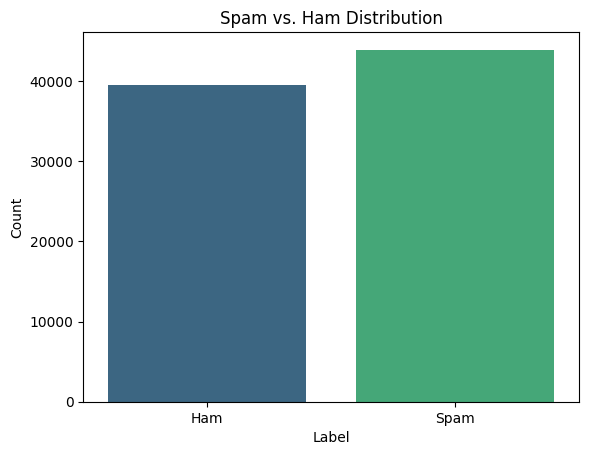

In [109]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.countplot(x='label', data=df, palette='viridis')
plt.title("Spam vs. Ham Distribution")
plt.xticks([0, 1], ['Ham', 'Spam'])
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()

The close counts between spam and ham messages suggest that the dataset is fairly balanced.

Ham: The count of Ham messages is slightly above 40,000.

Spam: The count of Spam messages is slightly below 50,000.

In [110]:
nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('wordnet')
# Step 1: Text Cleaning Function
def clean_text(text):
    # Step 1: Create a lemmatizer to simplify words to their base form.
    lemma = WordNetLemmatizer()

    # Step 2: Get a set of common words (stopwords) to remove from the text.
    stop = set(stopwords.words('english'))

    # Step 3: Tokenize the text by breaking it into individual words (tokens).
    tokens = word_tokenize(text)

    # Step 4: Remove any tokens that are not alphabetic (e.g., numbers or symbols).
    alpha_tokens = []  # Create an empty list to store alphabetic tokens.
    for token in tokens:
        if token.isalpha():  # Check if the token contains only letters.
            alpha_tokens.append(token)  # Add it to the list if it's alphabetic.

    # Step 5: Convert all tokens to lowercase and remove stopwords.
    meaningful_tokens = []  # Create a list to store meaningful tokens.
    for token in alpha_tokens:
        token_lower = token.lower()  # Convert the token to lowercase.
        if token_lower not in stop:  # Check if the token is not in the stopword list.
            meaningful_tokens.append(token_lower)  # Add it to the list.

    # Step 6: Lemmatize each token to convert it to its base form.
    lemmatized_tokens = []  # Create a list to store lemmatized tokens.
    for token in meaningful_tokens:
        lemmatized_token = lemma.lemmatize(token)  # Simplify the token to its base form.
        lemmatized_tokens.append(lemmatized_token)  # Add the lemmatized token to the list.

    # Step 7: Combine all the cleaned tokens back into a single string.
    cleaned_text = ' '.join(lemmatized_tokens)

    return cleaned_text


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [111]:
from tqdm import tqdm
tqdm.pandas()

# Apply the clean_text function to the 'text' column with progress bar
df['cleaned_email'] = df['text'].progress_apply(clean_text)

100%|██████████| 83448/83448 [04:45<00:00, 291.78it/s]


In [112]:
df

,label,text,cleaned_email
0,1,ounce feather bowl hummingbird opec moment ala...,ounce feather bowl hummingbird opec moment ala...
1,1,wulvob get your medircations online qnb ikud v...,wulvob get medircations online qnb ikud viagra...
2,0,computer connection from cnn com wednesday es...,computer connection cnn com wednesday escapenu...
3,1,university degree obtain a prosperous future m...,university degree obtain prosperous future mon...
4,0,thanks for all your answers guys i know i shou...,thanks answer guy know checked rsync manual wo...
...,...,...,...
83443,0,hi given a date how do i get the last date of ...,hi given date get last date month data form yy...
83444,1,now you can order software on cd or download i...,order software cd download site immediately de...
83445,1,dear valued member canadianpharmacy provides a...,dear valued member canadianpharmacy provides w...
83446,0,subscribe change profile contact us long term ...,subscribe change profile contact u long term e...


In [113]:
# Step 2: Feature Engineering
# Add new features to help identify spam based on common patterns
spam_keywords = [
    'free', 'win', 'urgent', 'money', 'offer', 'cash', 'credit',
    'limited', 'prize', 'buy now', 'discount', 'act now'
]

In [114]:
# Count the number of spam-related keywords in each email
def count_spam_keywords(text):
    spam_count = 0

    # Iterate through each keyword in the spam_keywords list.
    for word in spam_keywords:
        # Count how many times the keyword appears in the text.
        word_count = text.count(word)
        spam_count += word_count

    # Return the total number of spam keywords found in the text.
    return spam_count


In [115]:
def detect_spam_phrases(text):
    spam_phrases = ['win cash', 'limited time', 'act now']  # List of spam-related phrases

    # Initialize a variable to track if any phrase is found
    phrase_found = False

    # Loop through each phrase in the spam_phrases list
    for phrase in spam_phrases:
        # Check if the current phrase is in the text
        if phrase in text:
            phrase_found = True  # Mark as found if the phrase is in the text
            break

    return phrase_found


In [116]:
def contains_discount(text):
    pattern = r'\b\d{1,2}% off\b'

    # Use re.search to check if the pattern is found in the text
    match = re.search(pattern, text)

    # If a match is found, return True; otherwise, return False
    if match:
        return True
    else:
        return False

In [117]:
df['spam_keyword_count'] = df['cleaned_email'].apply(count_spam_keywords)
df['contains_spam_phrases'] = df['cleaned_email'].apply(detect_spam_phrases).astype(int)
df['contains_discount'] = df['text'].apply(contains_discount).astype(int)
df['total_spam_indicators'] = (
    df['spam_keyword_count'] + df['contains_spam_phrases'] + df['contains_discount']
)

In [118]:
df.head(20)

,label,text,cleaned_email,spam_keyword_count,contains_spam_phrases,contains_discount,total_spam_indicators
0,1,ounce feather bowl hummingbird opec moment ala...,ounce feather bowl hummingbird opec moment ala...,0,0,0,0
1,1,wulvob get your medircations online qnb ikud v...,wulvob get medircations online qnb ikud viagra...,0,0,0,0
2,0,computer connection from cnn com wednesday es...,computer connection cnn com wednesday escapenu...,3,0,0,3
3,1,university degree obtain a prosperous future m...,university degree obtain prosperous future mon...,2,0,0,2
4,0,thanks for all your answers guys i know i shou...,thanks answer guy know checked rsync manual wo...,0,0,0,0
5,0,larry king live at escapenumber escapenumber p...,larry king live escapenumber escapenumber p et...,0,0,0,0
6,0,michael pobega wrote i'm not sure if it's the ...,michael pobega wrote sure mpl mozilla allow di...,1,0,0,1
7,0,hi i have this error tr sample escapenumber es...,hi error tr sample escapenumber escapenumber e...,0,0,0,0
8,1,works gateway world art explore tattooing full...,work gateway world art explore tattooing full ...,0,0,0,0
9,1,upon this account he is not only very cautious...,upon account cautious escapenumber men would w...,0,0,0,0


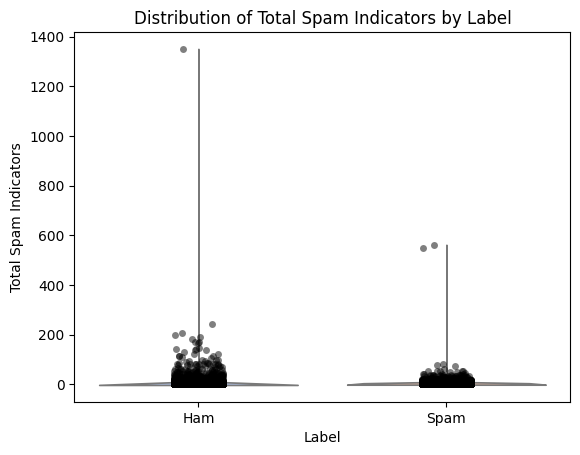

In [119]:
# Violin plot with strip plot
sns.violinplot(x='label', y='total_spam_indicators', data=df, palette='coolwarm', inner=None)
sns.stripplot(x='label', y='total_spam_indicators', data=df, color='k', alpha=0.5, jitter=True)

plt.xticks([0, 1], ['Ham', 'Spam'])
plt.title("Distribution of Total Spam Indicators by Label")
plt.xlabel("Label")
plt.ylabel("Total Spam Indicators")
plt.show()


The total spam indicators are significantly higher for the Spam category, indicating that these metrics are effective for distinguishing spam from non-spam messages.

Ham messages generally have lower total spam indicators, supporting the notion that these metrics are less frequent in non-spam messages.

Average presence of spam phrases:
label
0    0.000835
1    0.007903
Name: contains_spam_phrases, dtype: float64


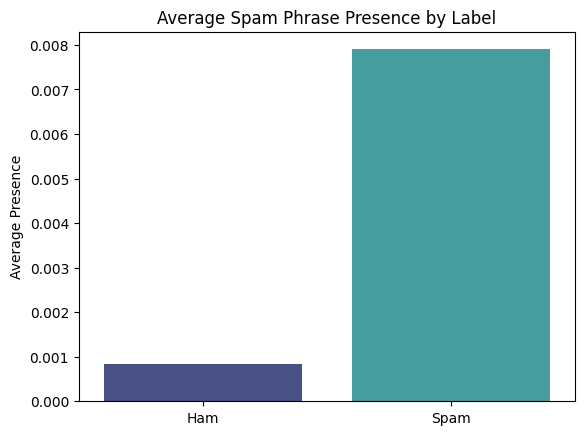

In [120]:
phrase_presence = df.groupby('label')['contains_spam_phrases'].mean()
print("Average presence of spam phrases:")
print(phrase_presence)

# Bar plot
sns.barplot(x=['Ham', 'Spam'], y=phrase_presence.values, palette='mako')
plt.title("Average Spam Phrase Presence by Label")
plt.ylabel("Average Presence")
plt.show()


The presence of spam phrases is a strong indicator of spam messages. The high
average presence of these phrases in the Spam category supports this.

The non-zero value for the Ham category suggests that some legitimate messages might still contain phrases typically associated with spam. This can lead to false positives in spam detection.

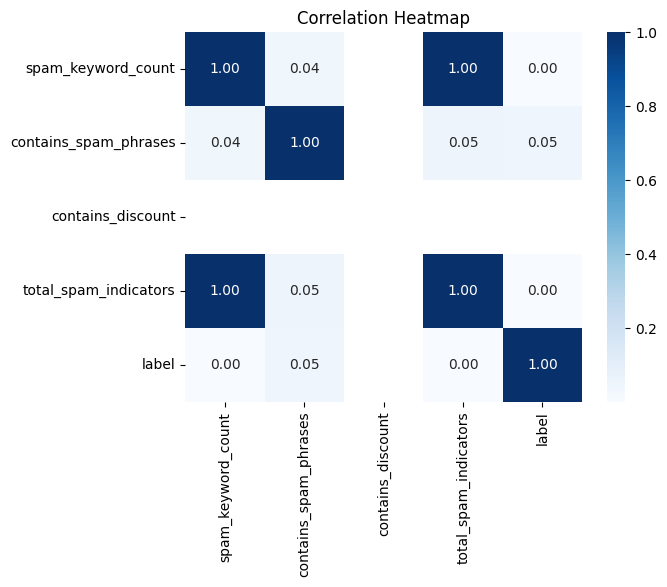

In [121]:
corr_matrix = df[['spam_keyword_count', 'contains_spam_phrases', 'contains_discount', 'total_spam_indicators', 'label']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='Blues', fmt='.2f')
plt.title("Correlation Heatmap")
plt.show()

In [122]:
print("Statistical Summary by Label:")
print(df.groupby('label')[['spam_keyword_count', 'total_spam_indicators']].describe())

Statistical Summary by Label:
      spam_keyword_count                                                  \
                   count      mean       std  min  25%  50%  75%     max   
label                                                                      
0                39538.0  1.499823  8.685942  0.0  0.0  0.0  1.0  1349.0   
1                43910.0  1.526759  4.633642  0.0  0.0  1.0  2.0   561.0   

      total_spam_indicators                                                  
                      count      mean       std  min  25%  50%  75%     max  
label                                                                        
0                   39538.0  1.500658  8.686758  0.0  0.0  0.0  1.0  1349.0  
1                   43910.0  1.534662  4.641550  0.0  0.0  1.0  2.0   561.0  


In [123]:
# Step 3: Text Vectorization (TF-IDF)
# Convert email text into numerical vectors using TF-IDF (Text Frequency-Inverse Document Frequency)
vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = vectorizer.fit_transform(df['cleaned_email'])  # Transform the cleaned text

In [124]:
# Step 4: Combine Features
# Add numerical spam indicators as additional features to the TF-IDF vectors
from scipy.sparse import hstack
X_combined = hstack([
    X_tfidf,
    df[['spam_keyword_count', 'total_spam_indicators']].values
])
y = df['label']  # Labels (spam=1, non-spam=0)


In [125]:
# Step 5: Train-Test Split
# Split the data into training and test sets (80% for training, 20% for testing)
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)

In [126]:
print(X_train.shape)  # Check the shape after combining
print(X_test.shape)

(66758, 5002)
(16690, 5002)


In [127]:
from sklearn.model_selection import RandomizedSearchCV
# Step 6: Hyperparameter Tuning for Logistic Regression using RandomizedSearchCV
# Define a grid of hyperparameters for tuning
log_reg_params = {
    'C': [0.1, 1, 10, 100, 1000],  # Regularization strength
    'solver': ['liblinear', 'lbfgs', 'saga'],  # Optimization algorithms
    'penalty': ['l2', 'none']  # Regularization type
}

log_reg = LogisticRegression()  # Initialize Logistic Regression model

# Initialize RandomizedSearchCV
log_reg_cv = RandomizedSearchCV(
    log_reg, log_reg_params, n_iter=10, scoring='accuracy', cv=5, verbose=1, n_jobs=-1, random_state=42
)

# Perform hyperparameter tuning
log_reg_cv.fit(X_train, y_train)

# Print the best parameters found during random search
print("Best Logistic Regression Parameters: ", log_reg_cv.best_params_)


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Logistic Regression Parameters:  {'solver': 'liblinear', 'penalty': 'l2', 'C': 10}


In [128]:
# Make predictions with the best Logistic Regression model
log_reg_pred = log_reg_cv.best_estimator_.predict(X_test)

In [129]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
# Step 7: Model Evaluation
# Function to evaluate models using classification reports and confusion matrices
def evaluate_model(name, y_test, y_pred):
    print(f"{name} Classification Report:\n")
    print(classification_report(y_test, y_pred))  # Display precision, recall, f1-score

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)  # Generate confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)  # Create ConfusionMatrixDisplay object
    disp.plot(cmap='Blues', values_format='d')
    plt.title(f"{name} - Confusion Matrix")
    plt.show()

Logistic Regression Classification Report:

              precision    recall  f1-score   support

           0       0.99      0.98      0.98      7938
           1       0.98      0.99      0.99      8752

    accuracy                           0.99     16690
   macro avg       0.99      0.99      0.99     16690
weighted avg       0.99      0.99      0.99     16690



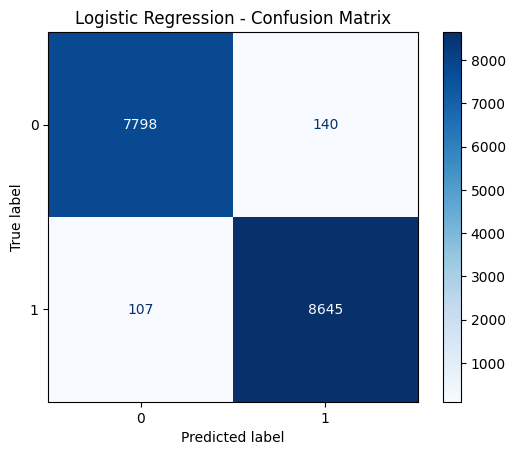

In [130]:
# Evaluate Logistic Regression
evaluate_model("Logistic Regression", y_test, log_reg_pred)

The Logistic Regression model was evaluated on a dataset of 16,690 samples, with a binary classification task where the target variable represents spam (1) and non-spam (0) emails.

Key Metrics:

Precision: The precision for non-spam (class 0) is 0.99, and for spam (class 1) is 0.98, indicating that the model is effective in correctly identifying both classes.

Recall: The recall for non-spam is 0.98, and for spam is 0.99, suggesting that the model is highly sensitive to both classes and detects almost all of them.

F1-Score: The F1-scores are 0.98 for non-spam and 0.99 for spam, balancing precision and recall, demonstrating that the model performs well across both classes.

Accuracy: The overall accuracy of the model is 0.99, indicating a very high classification performance.

Class Breakdown:

The non-spam consists of 7,938 samples, with the model achieving a precision of 0.99 and a recall of 0.98.

The spam consists of 8,752 samples, with the model achieving a precision of 0.98 and a recall of 0.99.

Averages:

Macro Average: The macro average for precision, recall, and F1-score are all 0.99, reflecting balanced performance across both classes.

Weighted Average: The weighted averages for precision, recall, and F1-score are also 0.99, accounting for the class imbalances.

Conclusion:

The Logistic Regression model demonstrates excellent performance in classifying spam and non-spam emails with high accuracy, precision, recall, and F1-score. Both classes are well-identified with minimal misclassification, making the model highly suitable for this task

In [131]:
# Show predictions and actual values as a DataFrame
predictions_df = pd.DataFrame({
    'Predictions': log_reg_pred[:10],
    'Actual': y_test[:10].values
})

print(predictions_df)

   Predictions  Actual
0            0       0
1            1       1
2            1       1
3            1       1
4            0       0
5            0       1
6            1       1
7            1       1
8            0       0
9            0       0


In [140]:
# Extract the first 10 email texts from the original DataFrame `df`
emails = df.iloc[y_test.index[:10]]['text']

# Create a DataFrame with the predictions, actual labels, and email text
predictions_df = pd.DataFrame({
    'Predictions': log_reg_pred[:10],
    'Actual': y_test[:10].values,
    'Email Text': emails
})

# Show the DataFrame
print(predictions_df)


       Predictions  Actual                                         Email Text
67681            0       0  accuweather escapenumber day forecast for beve...
61385            1       1  dear in christ the time has come for christian...
41829            1       1  hallway cosponsor pry reimbursable coat clumsy...
29172            1       1  does size matter' escapenumber of women said t...
35274            0       0  along zeng wrote hi all is there levene' test ...
6695             0       1  i'm about eighty percent sure chuckwalla anemo...
41685            1       1  dear reader ,\nwe are writing you on behalf of...
13023            1       1  hi kedda you've just received a postcard to vi...
62253            0       0   escapenumber escapenumber escapenumber home u...
38356            0       0  on sat may escapenumber escapenumber at escape...


In [145]:
single_email_text = """
Dear John,

I hope this message finds you well. I wanted to follow up on our recent meeting and discuss the next steps for our project. Please let me know your availability this week so we can schedule the next session.

Looking forward to hearing from you soon.

Best regards,
Alice
"""

cleaned_single_email = clean_text(single_email_text)
single_email_tfidf = vectorizer.transform([cleaned_single_email])
spam_keyword_count_single = count_spam_keywords(single_email_text)
contains_spam_phrases_single = detect_spam_phrases(single_email_text)
contains_discount_single = contains_discount(single_email_text)
total_spam_indicators_single = spam_keyword_count_single + contains_spam_phrases_single + contains_discount_single
X_single = hstack([
    single_email_tfidf,
    [[spam_keyword_count_single, total_spam_indicators_single]]
])
prediction = log_reg_cv.best_estimator_.predict(X_single)
prediction_label = "Spam" if prediction[0] == 1 else "Ham"
print("Predicted label:", prediction_label)


Predicted label: Ham


In [146]:
# Hyperparameter Tuning for Decision Tree using RandomizedSearchCV
# Define a grid of hyperparameters for tuning
from sklearn.tree import DecisionTreeClassifier
dt_params = {
    'max_depth': [5, 10, 15, None],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum samples required to split a node
    'min_samples_leaf': [1, 2, 4],  # Minimum samples required at a leaf node
    'criterion': ['gini', 'entropy'],  # Split criterion
}

dt = DecisionTreeClassifier()  # Initialize Decision Tree model

# Initialize RandomizedSearchCV
dt_cv = RandomizedSearchCV(
    dt, dt_params, n_iter=10, scoring='accuracy', cv=5, verbose=1, n_jobs=-1, random_state=42
)

# Perform hyperparameter tuning
dt_cv.fit(X_train, y_train)

# Print the best parameters found during random search
print("Best Decision Tree Parameters: ", dt_cv.best_params_)

# Make predictions with the best Decision Tree model
dt_pred = dt_cv.best_estimator_.predict(X_test)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Decision Tree Parameters:  {'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': None, 'criterion': 'gini'}


Decision Tree Classification Report:

              precision    recall  f1-score   support

           0       0.96      0.96      0.96      7938
           1       0.96      0.96      0.96      8752

    accuracy                           0.96     16690
   macro avg       0.96      0.96      0.96     16690
weighted avg       0.96      0.96      0.96     16690



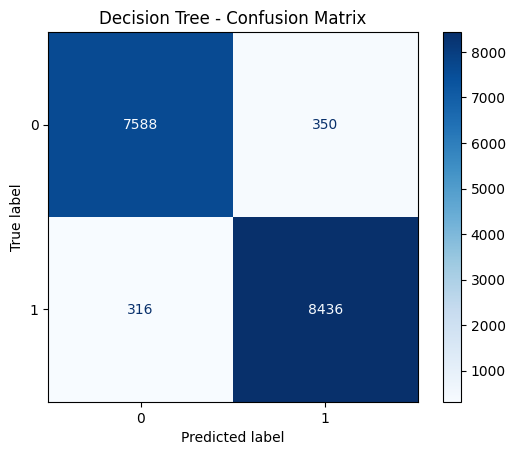

In [148]:
# Evaluate Decision Tree
evaluate_model("Decision Tree", y_test, dt_pred)

Decision Tree Classification Report Summary

The Decision Tree model achieved an overall accuracy of 96% on the test dataset, demonstrating robust performance in classifying emails as spam or ham.

Performance Metrics:

Precision: Both spam and ham emails had a precision of 96%, indicating a low rate of false positives.

Recall: Both classes had a recall of 96%, reflecting the model's effectiveness in capturing true positives.

F1-Score: The F1-score was 96% for both classes, signifying a good balance between precision and recall.

Insights:

The model performed equally well for both spam and ham emails, as indicated by the macro average and weighted average values.

This makes the Decision Tree model a reliable choice for this classification problem, though additional tuning or comparison with other models could further optimize results.

In [149]:
# Show predictions and actual values as a DataFrame
predictions_df_dt = pd.DataFrame({
    'Predictions': dt_pred[:10],
    'Actual': y_test[:10].values
})

print(predictions_df_dt)

   Predictions  Actual
0            0       0
1            1       1
2            1       1
3            1       1
4            0       0
5            1       1
6            1       1
7            1       1
8            0       0
9            0       0


In [150]:
# Extract the first 10 email texts from the original DataFrame `df`
emails = df.iloc[y_test.index[:10]]['text']

# Create a DataFrame with the predictions, actual labels, and email text
predictions_df = pd.DataFrame({
    'Predictions': dt_pred[:10],
    'Actual': y_test[:10].values,
    'Email Text': emails
})

# Show the DataFrame
print(predictions_df_dt)


   Predictions  Actual
0            0       0
1            1       1
2            1       1
3            1       1
4            0       0
5            1       1
6            1       1
7            1       1
8            0       0
9            0       0


In [152]:
single_email_text = """
Dear John,

I hope this message finds you well. I wanted to follow up on our recent meeting and discuss the next steps for our project. Please let me know your availability this week so we can schedule the next session.

Looking forward to hearing from you soon.

Best regards,
Alice
"""

cleaned_single_email = clean_text(single_email_text)
single_email_tfidf = vectorizer.transform([cleaned_single_email])
spam_keyword_count_single = count_spam_keywords(single_email_text)
contains_spam_phrases_single = detect_spam_phrases(single_email_text)
contains_discount_single = contains_discount(single_email_text)
total_spam_indicators_single = spam_keyword_count_single + contains_spam_phrases_single + contains_discount_single
X_single = hstack([
    single_email_tfidf,
    [[spam_keyword_count_single, total_spam_indicators_single]]
])
prediction = dt_cv.best_estimator_.predict(X_single)
prediction_label = "Spam" if prediction[0] == 1 else "Ham"
print("Predicted label:", prediction_label)


Predicted label: Ham


# **Conclusion**

The **Logistic Regression model** is the superior choice for spam email classification, offering higher accuracy (99%) and better-balanced performance metrics across both classes. The Decision Tree model, with an accuracy of 96%, is still a reliable alternative but falls slightly short compared to Logistic Regression.